In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
generative = combinators.BroadcastingTrace(1)

In [4]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [5]:
ssm_step = combinators.Model(ssm.ssm_step)

In [6]:
for t in range(zs.shape[0] - 1):
    zs[t+1], mu, sigma, delta = ssm_step((zs[t], mu, sigma, delta), t, trace=generative)

In [7]:
data = generative.unwrap(lambda k, rv: 'X_' in k)

In [8]:
num_particles = 100

In [9]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [10]:
init_ssm_generative = combinators.Model(ssm.init_ssm, hyper=ssm_params)
ssm_step_generative = combinators.Model(ssm.ssm_step)
smc_ssm = importance.ImportanceResampler.smc(ssm_step_generative, 50, initializer=init_ssm_generative)

In [11]:
init_ssm_proposal = combinators.Model(ssm.init_ssm, trainable=ssm_params)
ssm_step_proposal = combinators.Model(ssm.ssm_step)
ssm_proposal = combinators.Model.compose(
    combinators.Model.sequence(ssm_step_proposal, 50),
    init_ssm_proposal, intermediate_name='initializer'
)

In [12]:
ssm_importance = importance.ImportanceSampler(model=smc_ssm, proposal=ssm_proposal)

In [13]:
inference, init_ssm_params, elbos = importance.variational_importance(
    num_particles, ssm_importance, 1000,
    data, use_cuda=False, lr=1e-1, patience=500
)

10/06/2018 17:59:44 ELBO=-3.17856964e+02 at epoch 1
10/06/2018 17:59:45 ELBO=-4.56341156e+02 at epoch 2
10/06/2018 17:59:45 ELBO=-2.60367126e+02 at epoch 3
10/06/2018 17:59:46 ELBO=-1.99569901e+02 at epoch 4
10/06/2018 17:59:47 ELBO=-1.89948120e+02 at epoch 5
10/06/2018 17:59:48 ELBO=-3.47803528e+02 at epoch 6
10/06/2018 17:59:48 ELBO=-3.01876404e+02 at epoch 7
10/06/2018 17:59:49 ELBO=-2.26052719e+02 at epoch 8
10/06/2018 17:59:50 ELBO=-2.70335175e+02 at epoch 9
10/06/2018 17:59:50 ELBO=-2.56916809e+02 at epoch 10
10/06/2018 17:59:51 ELBO=-2.44187790e+02 at epoch 11
10/06/2018 17:59:51 ELBO=-3.12999329e+02 at epoch 12
10/06/2018 17:59:52 ELBO=-3.09576996e+02 at epoch 13
10/06/2018 17:59:52 ELBO=-2.93206848e+02 at epoch 14
10/06/2018 17:59:53 ELBO=-3.07936798e+02 at epoch 15
10/06/2018 17:59:54 ELBO=-2.46605270e+02 at epoch 16
10/06/2018 17:59:55 ELBO=-2.23170319e+02 at epoch 17
10/06/2018 17:59:56 ELBO=-2.34333054e+02 at epoch 18
10/06/2018 17:59:57 ELBO=-2.57723328e+02 at epoch 19
10

Epoch   705: reducing learning rate of group 0 to 5.0000e-02.


10/06/2018 18:10:59 ELBO=-2.55221039e+02 at epoch 707
10/06/2018 18:11:00 ELBO=-2.74731018e+02 at epoch 708
10/06/2018 18:11:01 ELBO=-2.61599609e+02 at epoch 709
10/06/2018 18:11:03 ELBO=-3.38857544e+02 at epoch 710
10/06/2018 18:11:04 ELBO=-2.57813171e+02 at epoch 711
10/06/2018 18:11:05 ELBO=-2.25907791e+02 at epoch 712
10/06/2018 18:11:06 ELBO=-1.94213318e+02 at epoch 713
10/06/2018 18:11:07 ELBO=-2.76985596e+02 at epoch 714
10/06/2018 18:11:08 ELBO=-2.30539383e+02 at epoch 715
10/06/2018 18:11:10 ELBO=-3.45137939e+02 at epoch 716
10/06/2018 18:11:10 ELBO=-2.62733673e+02 at epoch 717
10/06/2018 18:11:11 ELBO=-2.18279236e+02 at epoch 718
10/06/2018 18:11:12 ELBO=-3.15080841e+02 at epoch 719
10/06/2018 18:11:13 ELBO=-1.95533875e+02 at epoch 720
10/06/2018 18:11:14 ELBO=-2.38822998e+02 at epoch 721
10/06/2018 18:11:14 ELBO=-3.89546448e+02 at epoch 722
10/06/2018 18:11:15 ELBO=-1.89390884e+02 at epoch 723
10/06/2018 18:11:16 ELBO=-2.21021667e+02 at epoch 724
10/06/2018 18:11:17 ELBO=-3.

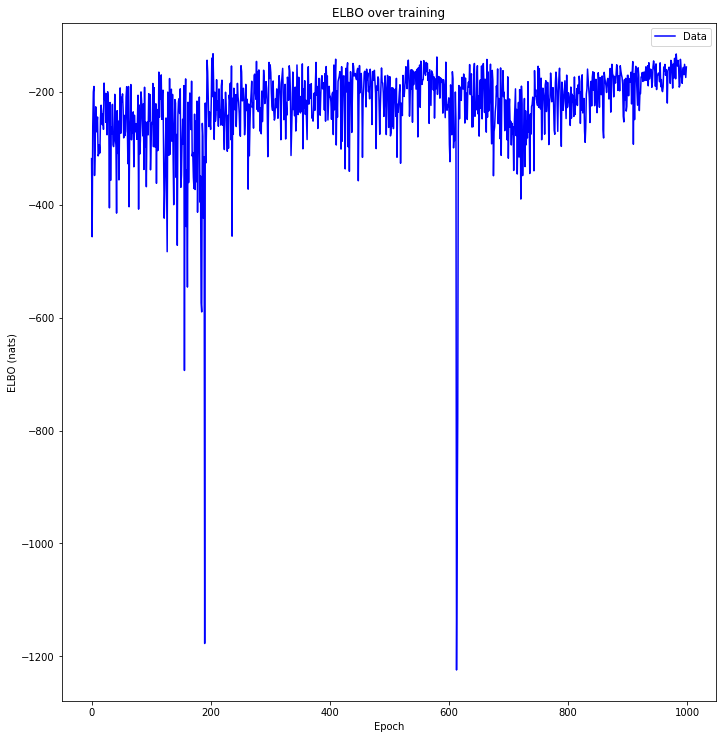

In [14]:
utils.plot_evidence_bounds(elbos)

In [15]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 0.681109
SMC MSE at time 2: 0.394003
SMC MSE at time 3: 0.834708
SMC MSE at time 4: 0.429742
SMC MSE at time 5: 1.257378
SMC MSE at time 6: 0.093620
SMC MSE at time 7: 0.113011
SMC MSE at time 8: 0.449130
SMC MSE at time 9: 2.380410
SMC MSE at time 10: 1.721893
SMC MSE at time 11: 4.272471
SMC MSE at time 12: 0.202116
SMC MSE at time 13: 0.027697
SMC MSE at time 14: 2.442339
SMC MSE at time 15: 1.327958
SMC MSE at time 16: 3.183699
SMC MSE at time 17: 0.799865
SMC MSE at time 18: 0.030198
SMC MSE at time 19: 0.004793
SMC MSE at time 20: 1.496101
SMC MSE at time 21: 0.093133
SMC MSE at time 22: 0.243977
SMC MSE at time 23: 2.307978
SMC MSE at time 24: 0.073700
SMC MSE at time 25: 0.176230
SMC MSE at time 26: 0.036277
SMC MSE at time 27: 0.018824
SMC MSE at time 28: 0.116716
SMC MSE at time 29: 0.021710
SMC MSE at time 30: 0.361269
SMC MSE at time 31: 0.208804
SMC MSE at time 32: 0.379724
SMC MSE at time 33: 0.348207
SMC MSE at time 34: 2.394111
SMC MSE at time 35: 0.4

In [16]:
particle_mh = mcmc.IndependentMH(smc_ssm, ssm_proposal, 1000)

In [17]:
samples, elbos = particle_mh(trace=importance.ResamplerTrace(num_particles, data=data))
inference = particle_mh.trace

In [18]:
inference

Trace{'mu': Normal([torch.FloatTensor of size 100]), 'sigma': Normal([torch.FloatTensor of size 100]), 'delta': Normal([torch.FloatTensor of size 100]), 'Z_0': Normal([torch.FloatTensor of size 100]), 'Z_1': Normal([torch.FloatTensor of size 100]), 'X_1': Normal([torch.FloatTensor of size 100]), 'Z_2': Normal([torch.FloatTensor of size 100]), 'X_2': Normal([torch.FloatTensor of size 100]), 'Z_3': Normal([torch.FloatTensor of size 100]), 'X_3': Normal([torch.FloatTensor of size 100]), 'Z_4': Normal([torch.FloatTensor of size 100]), 'X_4': Normal([torch.FloatTensor of size 100]), 'Z_5': Normal([torch.FloatTensor of size 100]), 'X_5': Normal([torch.FloatTensor of size 100]), 'Z_6': Normal([torch.FloatTensor of size 100]), 'X_6': Normal([torch.FloatTensor of size 100]), 'Z_7': Normal([torch.FloatTensor of size 100]), 'X_7': Normal([torch.FloatTensor of size 100]), 'Z_8': Normal([torch.FloatTensor of size 100]), 'X_8': Normal([torch.FloatTensor of size 100]), 'Z_9': Normal([torch.FloatTenso

In [19]:
generative

Trace{'Z_1': Normal([torch.FloatTensor of size 1]), 'X_1': Normal([torch.FloatTensor of size 1]), 'Z_2': Normal([torch.FloatTensor of size 1]), 'X_2': Normal([torch.FloatTensor of size 1]), 'Z_3': Normal([torch.FloatTensor of size 1]), 'X_3': Normal([torch.FloatTensor of size 1]), 'Z_4': Normal([torch.FloatTensor of size 1]), 'X_4': Normal([torch.FloatTensor of size 1]), 'Z_5': Normal([torch.FloatTensor of size 1]), 'X_5': Normal([torch.FloatTensor of size 1]), 'Z_6': Normal([torch.FloatTensor of size 1]), 'X_6': Normal([torch.FloatTensor of size 1]), 'Z_7': Normal([torch.FloatTensor of size 1]), 'X_7': Normal([torch.FloatTensor of size 1]), 'Z_8': Normal([torch.FloatTensor of size 1]), 'X_8': Normal([torch.FloatTensor of size 1]), 'Z_9': Normal([torch.FloatTensor of size 1]), 'X_9': Normal([torch.FloatTensor of size 1]), 'Z_10': Normal([torch.FloatTensor of size 1]), 'X_10': Normal([torch.FloatTensor of size 1]), 'Z_11': Normal([torch.FloatTensor of size 1]), 'X_11': Normal([torch.Flo

In [20]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 2.069423
SMC MSE at time 2: 1.945592
SMC MSE at time 3: 0.491677
SMC MSE at time 4: 1.722085
SMC MSE at time 5: 0.757511
SMC MSE at time 6: 1.065008
SMC MSE at time 7: 0.605544
SMC MSE at time 8: 0.014775
SMC MSE at time 9: 0.486673
SMC MSE at time 10: 0.586829
SMC MSE at time 11: 0.083562
SMC MSE at time 12: 0.135468
SMC MSE at time 13: 0.272408
SMC MSE at time 14: 1.316181
SMC MSE at time 15: 0.345560
SMC MSE at time 16: 0.494381
SMC MSE at time 17: 3.007579
SMC MSE at time 18: 5.969800
SMC MSE at time 19: 78.123352
SMC MSE at time 20: 74.782967
SMC MSE at time 21: 89.379730
SMC MSE at time 22: 98.039474
SMC MSE at time 23: 101.361404
SMC MSE at time 24: 129.644180
SMC MSE at time 25: 134.615448
SMC MSE at time 26: 136.814575
SMC MSE at time 27: 152.269714
SMC MSE at time 28: 199.117416
SMC MSE at time 29: 200.723816
SMC MSE at time 30: 210.173141
SMC MSE at time 31: 232.862610
SMC MSE at time 32: 251.043060
SMC MSE at time 33: 256.712189
SMC MSE at time 34: 289.95

In [21]:
elbos

tensor([-170.2692, -170.2692, -166.6538, -166.6538, -148.7410, -148.7410,
        -148.7410, -148.7410, -148.7410, -148.7410, -148.7410, -148.7410,
        -148.7410, -148.7410, -148.7410, -148.7410, -148.7410, -148.7410,
        -148.7410, -148.7410, -148.7410, -148.7410, -148.7410, -148.7410,
        -148.7410, -148.7410, -148.7410, -148.7410, -148.7410, -148.7410,
        -148.7410, -148.7410, -148.7410, -148.7410, -148.7410, -148.7410,
        -148.7410, -148.7410, -145.4515, -145.4515, -138.3046, -138.3046,
        -138.3046, -138.3046, -138.3046, -138.3046, -138.3046, -138.3046,
        -138.3046, -138.3046, -138.3046, -138.3046, -138.3046, -126.7883,
        -126.7883, -126.7883, -126.7883, -126.7883, -126.7883, -126.7883,
        -126.7883, -126.7883, -126.7883, -126.7883, -126.7883, -126.7883,
        -126.7883, -126.7883, -126.7883, -126.7883, -126.7883, -126.7883,
        -126.7883, -126.7883, -126.7883, -126.7883, -126.7883, -126.7883,
        -126.7883, -126.7883, -126.788